<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Twitter_multimodal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q -U "tensorflow-text==2.11.*"

In [4]:
!pip install -q tf-models-official==2.11.0

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import re
import shutil
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
def get_df(file):
    return pd.read_table(file,sep = '\t', lineterminator='\n')

In [97]:
train_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/tweets.txt')
test_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/tweets.txt')

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [100]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


## Flatten the image folder structure for both devset and testset for ease of processing

In [11]:
def flatten(directory, targetDir):
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(targetDir, filename)

            shutil.move(source, target)

    print("Moved", directory, "to", targetDir)

In [18]:
# Devset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/


In [12]:
# Testset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/


In [101]:
def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

In [102]:
train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)

In [103]:
from os import listdir

In [104]:

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35', 'sandyB_real_4', 'sandyB_real_6', 'sochi_fake_1fake'}

In [105]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'eclipse_video_01', 'syrianboy_1', 'varoufakis_1'}

In [106]:
print(train_df.shape, test_df.shape)

(14277, 8) (3755, 7)


In [107]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]

In [108]:
test_df = test_df[~test_df['imageId(s)'].isin(images_test_not_available)]
print(train_df.shape, test_df.shape)

(14258, 8) (1925, 7)


In [109]:
train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [110]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1925, 1925, 1925)

In [111]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

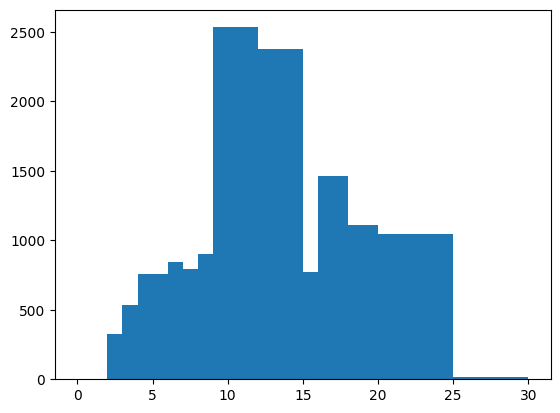

In [115]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [117]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>25:
        count+=1
print(count,len(l))
print(count/len(l))

17.0 14258
0.0011923130873895357


In [118]:
max_seq_length=25

# Visualize random tweets

In [151]:
import glob

In [152]:
DEV_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'
TEST_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

In [157]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name+'.*'):
    return name

In [158]:
def visualise(index, text_df, image_df, train=True):
  path = DEV_IMAGE_DIR if train else TEST_IMAGE_DIR
  text = text_df[index]
  image_path = find_image_from_name_in_dir(image_df[index],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  plt.title(text)
  plt.imshow(image)


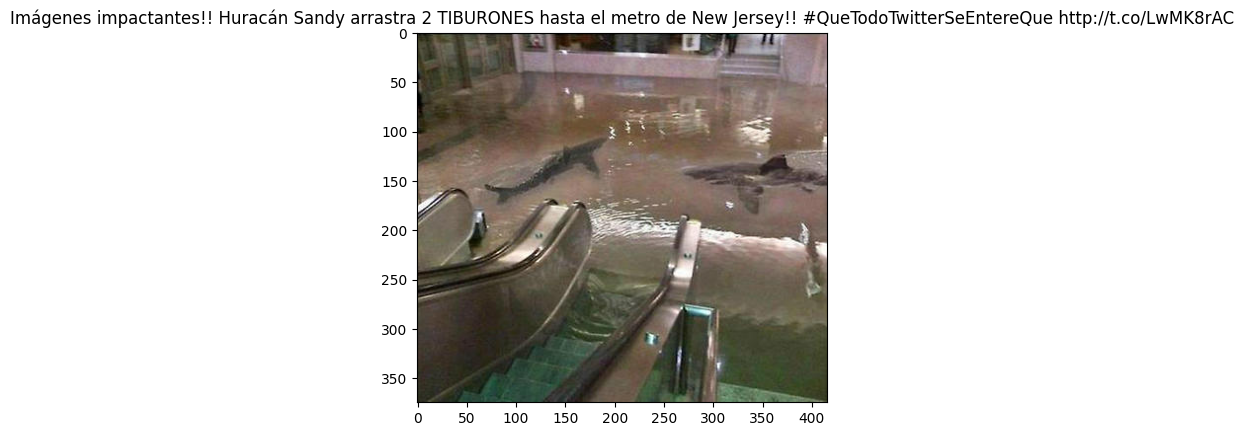

In [159]:
import random
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

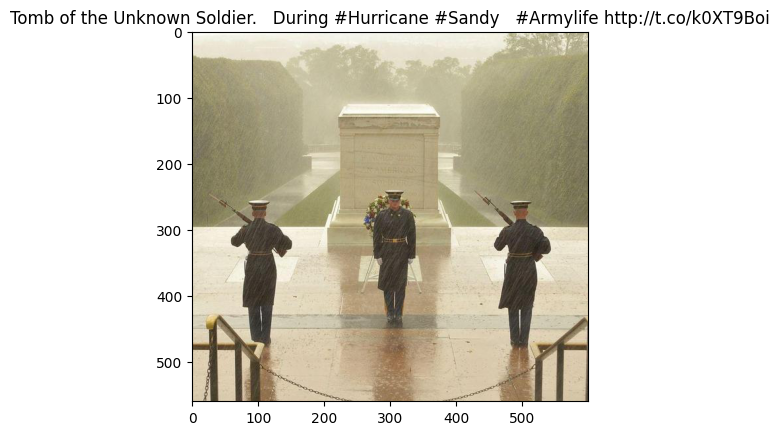

In [160]:
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

## Start of modeling